In [122]:
import os
from typing import Union, Optional

import torch.cuda
from torch.backends import cudnn

from nnunetv2.run.run_training import get_trainer_from_args, maybe_load_checkpoint

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
pretrained = os.path.join(os.environ['nnUNet_results'], 'Dataset213_ONKOI-all-from-208/nnUNetTrainer_noMirroringAxis2redRot__nnUNetPlans__3d_fullres_SepEncCMXv2/fold_0/checkpoint_best.pth')


dataset_name_or_id: Union[str, int] = '213'
configuration: str = '3d_fullres_SepEncCMXv2'
fold: Union[int, str] = 0
trainer_class_name: str = 'nnUNetTrainer_noMirroringAxis2redRot'
plans_identifier: str = 'nnUNetPlans'
pretrained_weights: Optional[str] = pretrained
num_gpus: int = 1
use_compressed_data: bool = False
export_validation_probabilities: bool = False
continue_training: bool = False
only_run_validation: bool = False
disable_checkpointing: bool = False
device: torch.device = torch.device('cuda')
num_epochs: int = 1000

if isinstance(fold, str):
    if fold != 'all':
        try:
            fold = int(fold)
        except ValueError as e:
            print(f'Unable to convert given value for fold to int: {fold}. fold must bei either "all" or an integer!')
            raise e

nnunet_trainer = get_trainer_from_args(dataset_name_or_id, configuration, fold, trainer_class_name,
                                        plans_identifier, use_compressed_data, device=device, num_epochs=num_epochs)

if disable_checkpointing:
    nnunet_trainer.disable_checkpointing = disable_checkpointing

assert not (continue_training and only_run_validation), f'Cannot set --c and --val flag at the same time. Dummy.'

maybe_load_checkpoint(nnunet_trainer, continue_training, only_run_validation, pretrained_weights)

if torch.cuda.is_available():
    cudnn.deterministic = False
    cudnn.benchmark = True

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

Number of trainable/total parameters in M: 54.02/54.02
################### Loading pretrained weights from file  /storage/nnUnet/nnUNet_trained_models/Dataset213_ONKOI-all-from-208/nnUNetTrainer_noMirroringAxis2redRot__nnUNetPlans__3d_fullres_SepEncCMXv2/fold_0/checkpoint_best.pth ###################
Below is the list of overlapping blocks in pretrained model and nnUNet architecture:
encoder.stages.0.0.0.convs.0.conv.weight shape torch.Size([32, 1, 1, 3, 3])
encoder.stages.0.0.0.convs.0.conv.bias shape torch.Size([32])
encoder.stages.0.0.0.convs.0.norm.weight shape torc

In [123]:
import numpy as np
nnunet_trainer.on_train_start()
nnunet_trainer.on_validation_epoch_start()
# data = next(nnunet_trainer.dataloader_val)

fn = '/media/medical/gasperp/projects/nnUnetv2_clone/nnUNet/nnunetv2/inference/test_patch.npz'
# with open(fn, 'wb') as f:
#     np.savez(f, data=data['data'].cpu().numpy(), target=data['target'][0].cpu().numpy())
ddd = np.load(fn)
data = {'data': torch.from_numpy(ddd['data']), 'target': [torch.from_numpy(ddd['target'])]}


This is the configuration used by this training:
Configuration name: 3d_fullres_SepEncCMXv2
 {'data_identifier': 'nnUNetPlans_3d_fullres', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 2, 'patch_size': [40, 192, 224], 'median_image_size_in_voxels': [94.0, 459.5, 466.0], 'spacing': [2.0, 0.5, 0.5], 'normalization_schemes': ['CTNormalization', 'ZScoreNormalization'], 'use_mask_for_norm': [False, False], 'UNet_class_name': 'PlainConvUNetSeparateEncoderCMXv2', 'UNet_base_num_features': 32, 'n_conv_per_stage_encoder': [2, 2, 2, 2, 2, 2], 'n_conv_per_stage_decoder': [2, 2, 2, 2, 2], 'num_pool_per_axis': [3, 5, 5], 'pool_op_kernel_sizes': [[1, 1, 1], [1, 2, 2], [1, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]], 'conv_kernel_sizes': [[1, 3, 3], [1, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]], 'unet_max_num_features': 320, 'resampling_fn_data': 'resample_data_or_seg_to_shape', 'resampling_fn_seg': 'resample_data_or_seg_to_shape', 'resampling_fn_data_kwargs': {'is_seg': False, 'ord

In [124]:
nnunet_trainer.network.encoder.FFMs_stage1[0].cross.heads[0].key0

Linear(in_features=32, out_features=16, bias=False)

In [125]:
def setup_hooks(d):
    # Visualize feature maps
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            if isinstance(output, torch.Tensor):
                activation[name] = output.detach().cpu().numpy()
            elif isinstance(output, (tuple, list)):
                for enum, o in enumerate(output):
                    activation[name + f'_{enum}'] = o.detach().cpu().numpy()
            else:
                print(f'Unknown output type: {type(output)}')
        return hook

    hooks = []

    hooks.append(nnunet_trainer.network.encoder.stages[0][0][0].convs[1].register_forward_hook(get_activation('skip0_CT')))
    hooks.append(nnunet_trainer.network.encoder.stages[1][0][0].convs[1].register_forward_hook(get_activation('skip1_CT')))
    hooks.append(nnunet_trainer.network.encoder.stages[2][0][0].convs[1].register_forward_hook(get_activation('skip2_CT')))
    hooks.append(nnunet_trainer.network.encoder.stages[3][0][0].convs[1].register_forward_hook(get_activation('skip3_CT')))
    hooks.append(nnunet_trainer.network.encoder.stages[4][0][0].convs[1].register_forward_hook(get_activation('skip4_CT')))

    hooks.append(nnunet_trainer.network.encoder.stages[0][1][0].convs[1].register_forward_hook(get_activation('skip0_MR')))
    hooks.append(nnunet_trainer.network.encoder.stages[1][1][0].convs[1].register_forward_hook(get_activation('skip1_MR')))
    hooks.append(nnunet_trainer.network.encoder.stages[2][1][0].convs[1].register_forward_hook(get_activation('skip2_MR')))
    hooks.append(nnunet_trainer.network.encoder.stages[3][1][0].convs[1].register_forward_hook(get_activation('skip3_MR')))
    hooks.append(nnunet_trainer.network.encoder.stages[4][1][0].convs[1].register_forward_hook(get_activation('skip4_MR')))
    
    hooks.append(nnunet_trainer.network.encoder.FRMs[0].register_forward_hook(get_activation('FRM_0')))
    hooks.append(nnunet_trainer.network.encoder.FRMs[1].register_forward_hook(get_activation('FRM_1')))
    hooks.append(nnunet_trainer.network.encoder.FRMs[2].register_forward_hook(get_activation('FRM_2')))
    hooks.append(nnunet_trainer.network.encoder.FRMs[3].register_forward_hook(get_activation('FRM_3')))
    hooks.append(nnunet_trainer.network.encoder.FRMs[4].register_forward_hook(get_activation('FRM_4')))
    
    hooks.append(nnunet_trainer.network.decoder.stages[0].convs[1].nonlin.register_forward_hook(get_activation('decoder0')))
    hooks.append(nnunet_trainer.network.decoder.stages[1].convs[1].nonlin.register_forward_hook(get_activation('decoder1')))
    hooks.append(nnunet_trainer.network.decoder.stages[2].convs[1].nonlin.register_forward_hook(get_activation('decoder2')))
    hooks.append(nnunet_trainer.network.decoder.stages[3].convs[1].nonlin.register_forward_hook(get_activation('decoder3')))
    hooks.append(nnunet_trainer.network.decoder.stages[4].convs[1].nonlin.register_forward_hook(get_activation('decoder4')))
    hooks.append(nnunet_trainer.network.decoder.seg_layers[4].register_forward_hook(get_activation('pred_seg')))


    # output = nnunet_trainer.network.encoder(d[:,[0]], d[:,[1]])
    nnunet_trainer.network.eval()
    output = nnunet_trainer.network(d)

    for h in hooks:
        h.remove()
        
    return activation

In [126]:
%matplotlib inline
from matplotlib import pyplot as plt
"""
nnunet_trainer.network.encoder.stages 0-5
each stage in encoder has two branches: CT and MR 0-1
each branch has a single StackedConvBlocks (double-conv) block, so 0
"""

d = data['data'][[0]].to('cuda:0')
activation = setup_hooks(d)

In [127]:
for k in list(activation.keys()):
    if isinstance(activation[k], (list, tuple)):
        print(k, len(activation[k]), activation[k][0].shape)
    else:
        print(k, activation[k].shape)

skip0_CT (1, 32, 40, 192, 224)
skip0_MR (1, 32, 40, 192, 224)
FRM_0_0 (1, 32, 40, 192, 224)
FRM_0_1 (1, 32, 40, 192, 224)
skip1_CT (1, 64, 40, 96, 112)
skip1_MR (1, 64, 40, 96, 112)
FRM_1_0 (1, 64, 40, 96, 112)
FRM_1_1 (1, 64, 40, 96, 112)
skip2_CT (1, 128, 40, 48, 56)
skip2_MR (1, 128, 40, 48, 56)
FRM_2_0 (1, 128, 40, 48, 56)
FRM_2_1 (1, 128, 40, 48, 56)
skip3_CT (1, 256, 20, 24, 28)
skip3_MR (1, 256, 20, 24, 28)
FRM_3_0 (1, 256, 20, 24, 28)
FRM_3_1 (1, 256, 20, 24, 28)
skip4_CT (1, 320, 10, 12, 14)
skip4_MR (1, 320, 10, 12, 14)
FRM_4_0 (1, 320, 10, 12, 14)
FRM_4_1 (1, 320, 10, 12, 14)
decoder0 (1, 320, 10, 12, 14)
decoder1 (1, 256, 20, 24, 28)
decoder2 (1, 128, 40, 48, 56)
decoder3 (1, 64, 40, 96, 112)
decoder4 (1, 32, 40, 192, 224)
pred_seg (1, 31, 40, 192, 224)


In [128]:
[i.shape for i in data['target']]

[torch.Size([2, 1, 40, 192, 224])]

In [129]:
# write me a function to plot activation maps in two rows, 1. row should be the max projection, 2. row should be the mean projection
# the function should take the activation dict and the name of the layer as input

def plot(activation, t, B, SLC, img):
    fig, axes = plt.subplots(3, len(activation)+2, figsize=(25, 4))

    for i, key in enumerate(activation.keys()):
        if key == 'pred_seg':
            FM = activation[key][B][1:]
        else:
            FM = activation[key][B]
        axes[0,i].imshow(FM.max(0)[SLC], cmap='gray')
        axes[1,i].imshow(FM.mean(0)[SLC], cmap='gray')
        axes[2,i].imshow(FM.std(0)[SLC], cmap='gray')
        axes[0,i].set_title(key)
        
    axes[0,0].set_ylabel('max')
    axes[1,0].set_ylabel('mean')
    axes[2,0].set_ylabel('std')

    axes[0,-2].imshow(t[SLC], cmap='gray')
    axes[1,-2].imshow(t[SLC], cmap='gray')
    axes[2,-2].imshow(t[SLC], cmap='gray')
    
    axes[0,-1].imshow(img[SLC], cmap='gray')
    axes[1,-1].imshow(img[SLC], cmap='gray')
    axes[2,-1].imshow(img[SLC], cmap='gray')
    plt.tight_layout()
    plt.show()

In [130]:
d.shape

torch.Size([1, 2, 40, 192, 224])

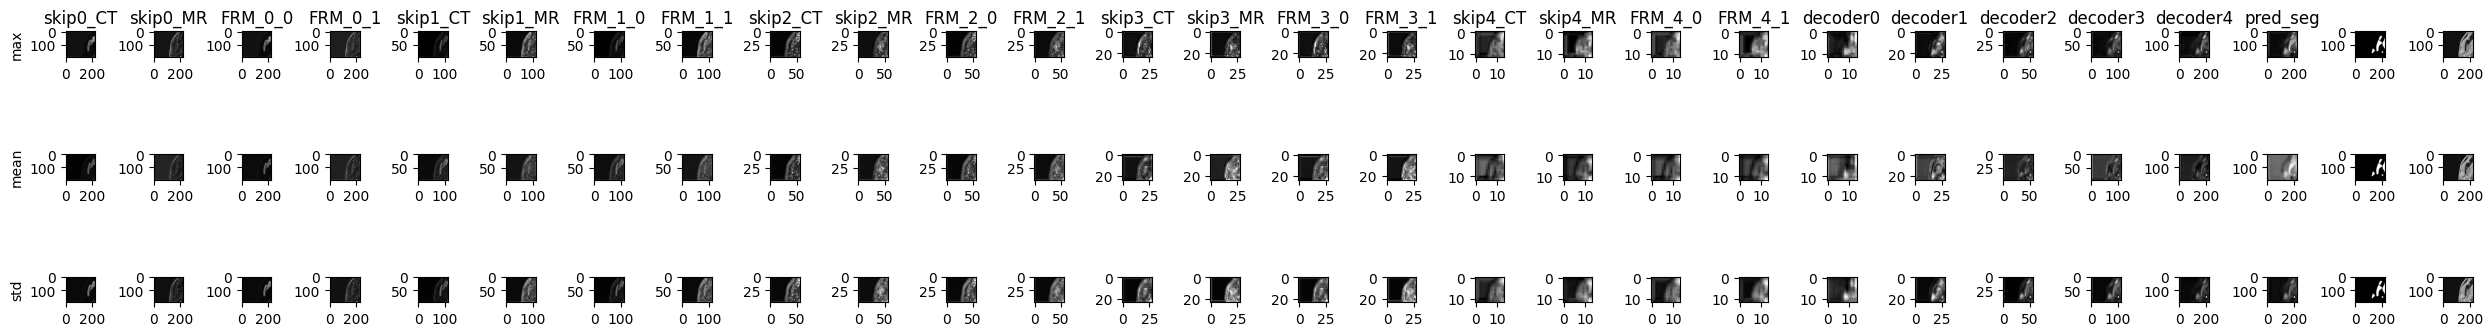

In [131]:
B = 0
SLC = 2

t = data['target'][0][B][0].cpu().numpy().astype(bool).astype(int)

plot(activation, t, B, SLC, d[0][1].cpu().numpy())

In [132]:
def setup_hooks(d):
    # Visualize feature maps
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            if isinstance(output, torch.Tensor):
                activation[name] = output.detach().cpu().numpy()
            elif isinstance(output, (tuple, list)):
                for enum, o in enumerate(output):
                    activation[name + f'_{enum}'] = o.detach().cpu().numpy()
            else:
                print(f'Unknown output type: {type(output)}')
        return hook

    hooks = []
    
    hooks.append(nnunet_trainer.network.encoder.FRMs[0].register_forward_hook(get_activation('FRM_0')))
    hooks.append(nnunet_trainer.network.encoder.FRMs[1].register_forward_hook(get_activation('FRM_1')))
    hooks.append(nnunet_trainer.network.encoder.FRMs[2].register_forward_hook(get_activation('FRM_2')))
    hooks.append(nnunet_trainer.network.encoder.FRMs[3].register_forward_hook(get_activation('FRM_3')))
    hooks.append(nnunet_trainer.network.encoder.FRMs[4].register_forward_hook(get_activation('FRM_4')))
    
    hooks.append(nnunet_trainer.network.encoder.FFMs_stage1[0].register_forward_hook(get_activation('attn0')))
    hooks.append(nnunet_trainer.network.encoder.FFMs_stage1[1].register_forward_hook(get_activation('attn1')))
    hooks.append(nnunet_trainer.network.encoder.FFMs_stage1[2].register_forward_hook(get_activation('attn2')))
    hooks.append(nnunet_trainer.network.encoder.FFMs_stage1[3].register_forward_hook(get_activation('attn3')))
    hooks.append(nnunet_trainer.network.encoder.FFMs_stage1[4].register_forward_hook(get_activation('attn4')))

    # output = nnunet_trainer.network.encoder(d[:,[0]], d[:,[1]])
    nnunet_trainer.network.eval()
    output = nnunet_trainer.network(d)

    for h in hooks:
        h.remove()
        
    return activation

In [133]:
activation = setup_hooks(d)

for k in list(activation.keys()):
    if isinstance(activation[k], (list, tuple)):
        print(k, len(activation[k]), activation[k][0].shape)
    else:
        print(k, activation[k].shape)

FRM_0_0 (1, 32, 40, 192, 224)
FRM_0_1 (1, 32, 40, 192, 224)
attn0_0 (1, 32, 40, 192, 224)
attn0_1 (1, 32, 40, 192, 224)
FRM_1_0 (1, 64, 40, 96, 112)
FRM_1_1 (1, 64, 40, 96, 112)
attn1_0 (1, 64, 40, 96, 112)
attn1_1 (1, 64, 40, 96, 112)
FRM_2_0 (1, 128, 40, 48, 56)
FRM_2_1 (1, 128, 40, 48, 56)
attn2_0 (1, 128, 40, 48, 56)
attn2_1 (1, 128, 40, 48, 56)
FRM_3_0 (1, 256, 20, 24, 28)
FRM_3_1 (1, 256, 20, 24, 28)
attn3_0 (1, 256, 20, 24, 28)
attn3_1 (1, 256, 20, 24, 28)
FRM_4_0 (1, 320, 10, 12, 14)
FRM_4_1 (1, 320, 10, 12, 14)
attn4_0 (1, 320, 10, 12, 14)
attn4_1 (1, 320, 10, 12, 14)


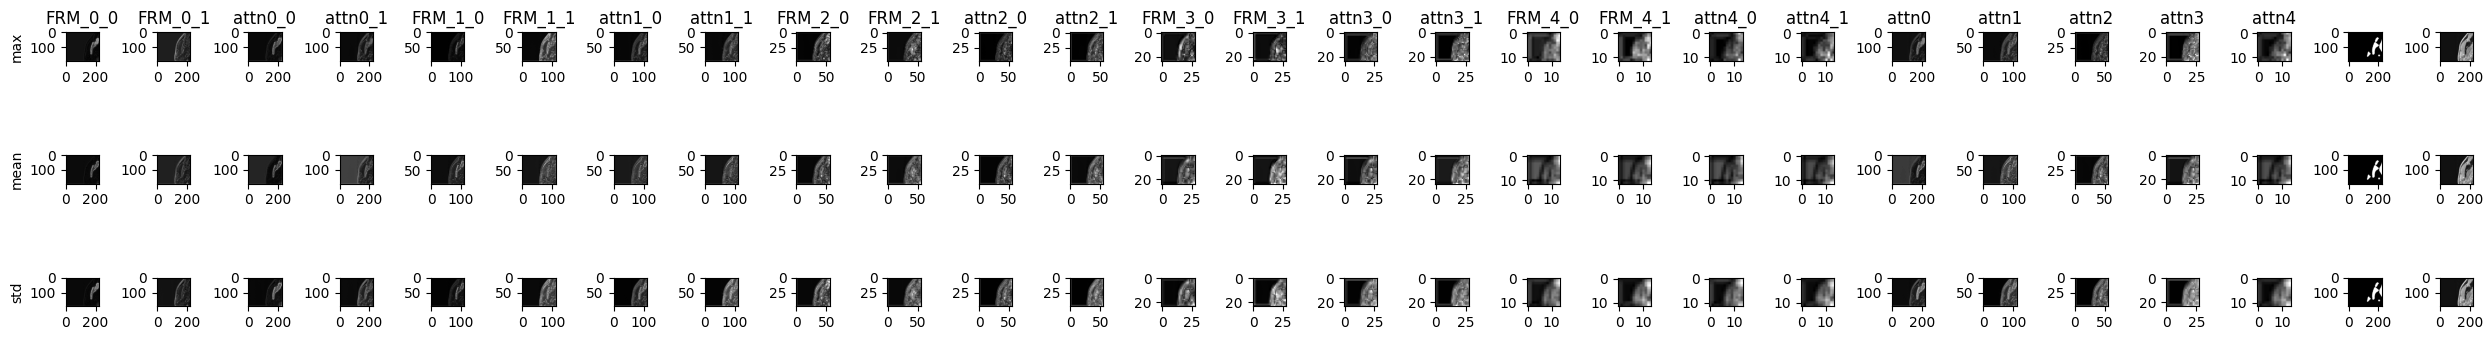

In [134]:
activation['attn0'] = activation['attn0_0'] + activation['attn0_1']
activation['attn1'] = activation['attn1_0'] + activation['attn1_1']
activation['attn2'] = activation['attn2_0'] + activation['attn2_1']
activation['attn3'] = activation['attn3_0'] + activation['attn3_1']
activation['attn4'] = activation['attn4_0'] + activation['attn4_1']

t = data['target'][0][B][0].cpu().numpy().astype(bool).astype(int)

plot(activation, t, B, SLC, d[0][1].cpu().numpy())

In [135]:
nnunet_trainer.network.encoder.FFMs_stage1[0].cross.heads[0]

EfficientCrossAttentionHead(
  (key0): Linear(in_features=32, out_features=16, bias=False)
  (key1): Linear(in_features=32, out_features=16, bias=False)
  (query0): Linear(in_features=32, out_features=16, bias=False)
  (query1): Linear(in_features=32, out_features=16, bias=False)
  (value0): Linear(in_features=32, out_features=16, bias=False)
  (value1): Linear(in_features=32, out_features=16, bias=False)
)

In [136]:
def setup_hooks(d):
    # Visualize feature maps
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            if isinstance(output, torch.Tensor):
                activation[name] = output.detach().cpu().numpy()
            elif isinstance(output, (tuple, list)):
                for enum, o in enumerate(output):
                    activation[name + f'_{enum}'] = o.detach().cpu().numpy()
            else:
                print(f'Unknown output type: {type(output)}')
        return hook

    hooks = []
    
    hooks.append(nnunet_trainer.network.encoder.FFMs_stage1[0].cross.heads[0].key0.register_forward_hook(get_activation('key0')))
    hooks.append(nnunet_trainer.network.encoder.FFMs_stage1[0].cross.heads[0].value0.register_forward_hook(get_activation('value0')))
    hooks.append(nnunet_trainer.network.encoder.FFMs_stage1[0].cross.heads[0].query1.register_forward_hook(get_activation('query1')))
    

    # output = nnunet_trainer.network.encoder(d[:,[0]], d[:,[1]])
    nnunet_trainer.network.eval()
    output = nnunet_trainer.network(d)

    for h in hooks:
        h.remove()
        
    return activation

In [137]:
activation = setup_hooks(d)

for k in list(activation.keys()):
    if isinstance(activation[k], (list, tuple)):
        print(k, len(activation[k]), activation[k][0].shape)
    else:
        print(k, activation[k].shape)

key0 (1, 1720320, 16)
query1 (1, 1720320, 16)
value0 (1, 1720320, 16)


In [148]:
k0 = torch.from_numpy(activation['key0'])
v0 = torch.from_numpy(activation['value0'])
q1 = torch.from_numpy(activation['query1'])

print(k0.shape, v0.shape, q1.shape)

k0 = k0.softmax(dim=-2)
w0 = k0.transpose(-2, -1) @ v0
q1 = q1.softmax(dim=-1)
attn_x1 = q1 @ w0

w0.shape, attn_x1.shape

torch.Size([1, 1720320, 16]) torch.Size([1, 1720320, 16]) torch.Size([1, 1720320, 16])


(torch.Size([1, 16, 16]), torch.Size([1, 1720320, 16]))

In [155]:
(q1[0,:1000] @ k0[0,:1000].transpose(-2, -1)).sum(0)

tensor([0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006, 0.0006, 

In [139]:
k0

tensor([[[5.7616e-07, 5.7594e-07, 5.6548e-07,  ..., 5.6989e-07,
          5.7811e-07, 5.8202e-07],
         [5.7300e-07, 5.7877e-07, 5.6809e-07,  ..., 5.7249e-07,
          5.8030e-07, 5.7704e-07],
         [5.7711e-07, 5.7691e-07, 5.6838e-07,  ..., 5.7346e-07,
          5.7858e-07, 5.7852e-07],
         ...,
         [5.7246e-07, 5.7634e-07, 5.7292e-07,  ..., 5.7586e-07,
          5.7788e-07, 5.7330e-07],
         [5.7199e-07, 5.7561e-07, 5.7351e-07,  ..., 5.7505e-07,
          5.7873e-07, 5.7351e-07],
         [5.7196e-07, 5.7467e-07, 5.7352e-07,  ..., 5.7596e-07,
          5.7897e-07, 5.7365e-07]]])

In [140]:
q1

tensor([[[0.0624, 0.0624, 0.0622,  ..., 0.0630, 0.0621, 0.0634],
         [0.0624, 0.0622, 0.0623,  ..., 0.0629, 0.0625, 0.0631],
         [0.0625, 0.0624, 0.0623,  ..., 0.0629, 0.0623, 0.0632],
         ...,
         [0.0625, 0.0624, 0.0627,  ..., 0.0630, 0.0617, 0.0630],
         [0.0624, 0.0620, 0.0626,  ..., 0.0631, 0.0615, 0.0633],
         [0.0625, 0.0620, 0.0626,  ..., 0.0632, 0.0616, 0.0630]]])

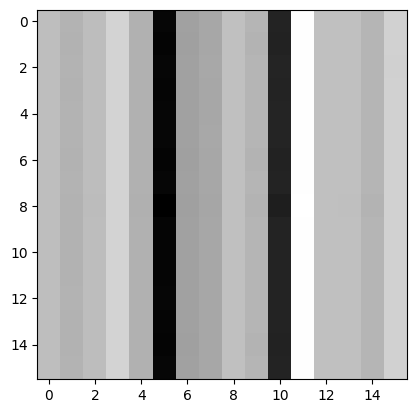

In [141]:
plt.imshow(w0[0].cpu().numpy(), cmap='gray')

In [142]:
w0[0].cpu().numpy().round(2)

array([[-0.01, -0.02, -0.01,  0.01, -0.03, -0.22, -0.04, -0.04, -0.01,
        -0.02, -0.19,  0.06, -0.01, -0.01, -0.02,  0.01],
       [-0.01, -0.02, -0.01,  0.01, -0.03, -0.22, -0.04, -0.04, -0.01,
        -0.02, -0.19,  0.06, -0.01, -0.01, -0.02,  0.01],
       [-0.01, -0.02, -0.01,  0.01, -0.03, -0.22, -0.04, -0.04, -0.01,
        -0.02, -0.18,  0.06, -0.01, -0.01, -0.02,  0.01],
       [-0.01, -0.02, -0.01,  0.01, -0.03, -0.22, -0.04, -0.04, -0.01,
        -0.02, -0.19,  0.06, -0.01, -0.01, -0.02,  0.01],
       [-0.01, -0.02, -0.01,  0.01, -0.03, -0.22, -0.04, -0.04, -0.01,
        -0.02, -0.19,  0.06, -0.01, -0.01, -0.02,  0.01],
       [-0.01, -0.02, -0.01,  0.01, -0.03, -0.22, -0.04, -0.04, -0.01,
        -0.02, -0.19,  0.06, -0.01, -0.01, -0.02,  0.01],
       [-0.01, -0.02, -0.01,  0.01, -0.03, -0.22, -0.04, -0.04, -0.01,
        -0.02, -0.19,  0.06, -0.01, -0.01, -0.02,  0.01],
       [-0.01, -0.02, -0.01,  0.01, -0.03, -0.22, -0.04, -0.04, -0.01,
        -0.02, -0.19,  0.0

In [143]:
attn_x1.shape, attn_x1.transpose(-2, -1).shape, attn_x1.transpose(-2, -1)[0].reshape(16, 40, 192, 224).shape

(torch.Size([1, 1720320, 16]),
 torch.Size([1, 16, 1720320]),
 torch.Size([16, 40, 192, 224]))

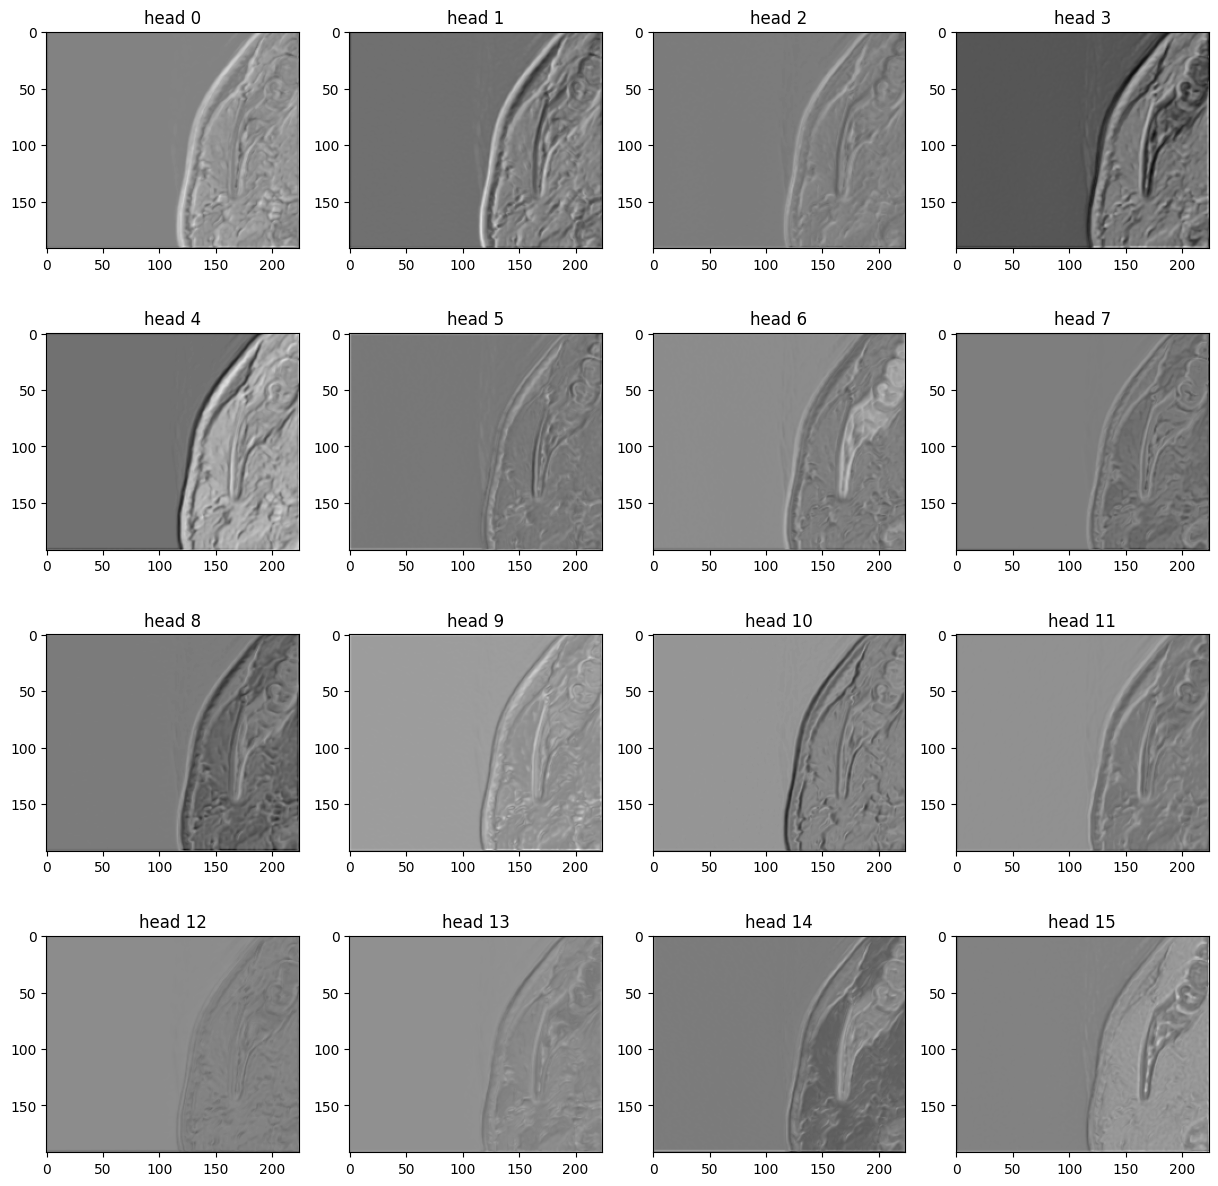

In [144]:
plot_q1 = q1.transpose(-2, -1)[0].reshape(16, 40, 192, 224)
fig, axes = plt.subplots(4,4, figsize=(15, 15))
axes = axes.ravel()
SLC = 0
vmin, vmax = plot_q1[:, SLC].min().item(), plot_q1[:, SLC].max().item()
for i in range(16):
    axes[i].imshow(plot_q1[i][SLC].cpu().numpy(), cmap='gray', vmin=vmin, vmax=vmax)
    axes[i].set_title(f'head {i}')

-0.22009100019931793 0.06071121618151665


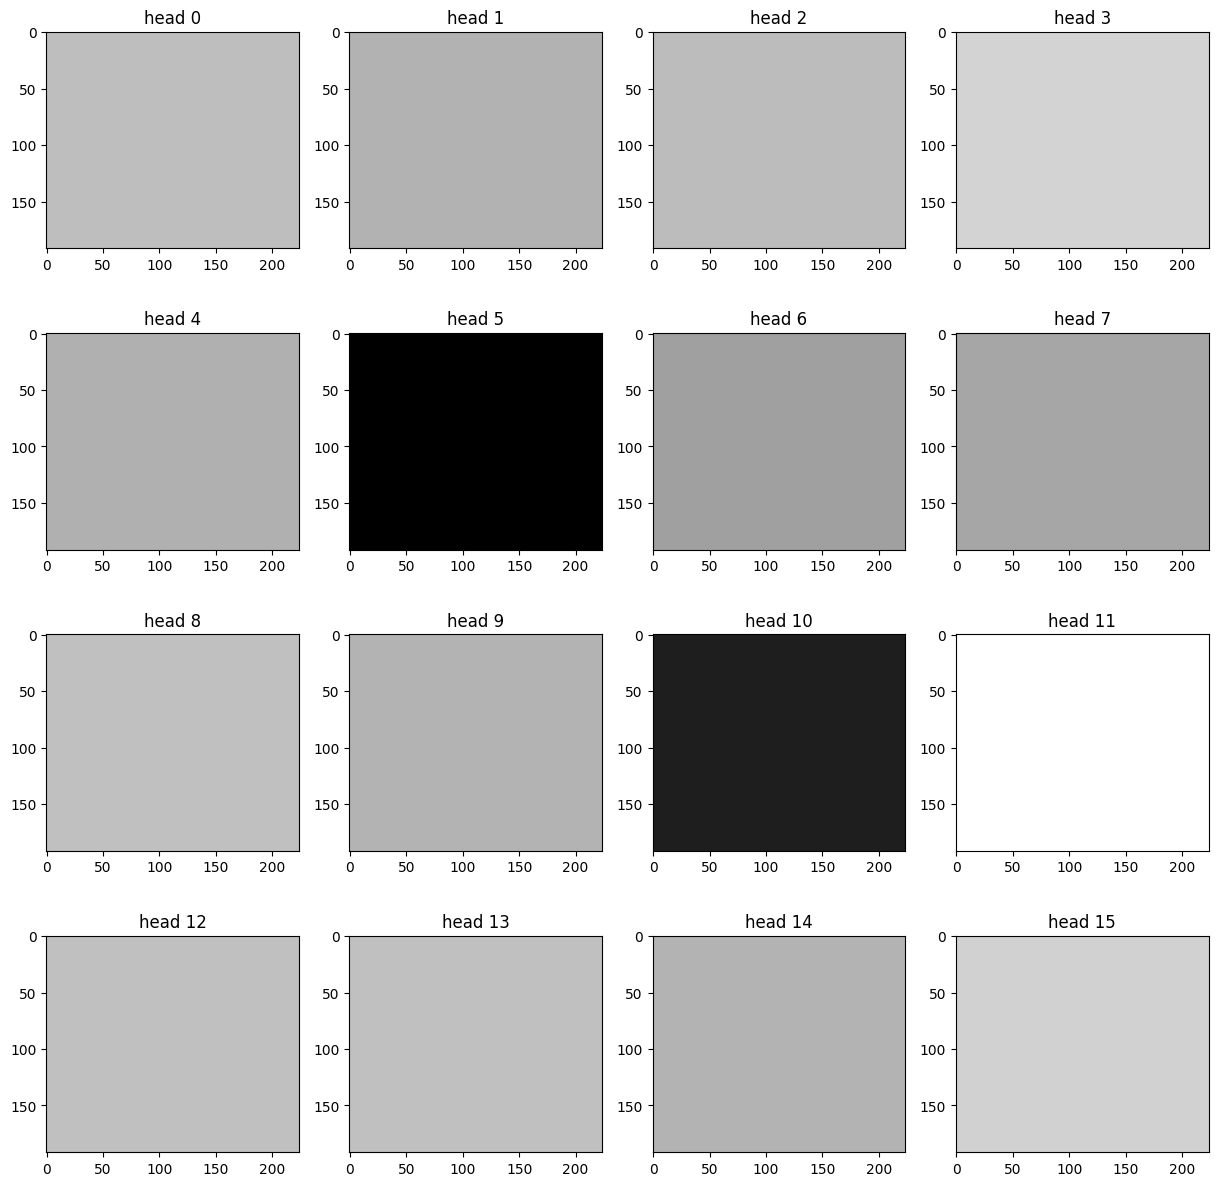

In [145]:
attended_x1 = attn_x1.transpose(-2, -1)[0].reshape(16, 40, 192, 224)
fig, axes = plt.subplots(4,4, figsize=(15, 15))
axes = axes.ravel()
vmin, vmax = attended_x1[:, SLC].min().item(), attended_x1[:, SLC].max().item()
print(vmin, vmax)
for i in range(16):
    axes[i].imshow(attended_x1[i][SLC].cpu().numpy(), cmap='gray', vmin=vmin, vmax=vmax)
    # axes[i].hist(attended_x1[i][SLC].cpu().numpy().flatten()) #, vmin=vmin, vmax=vmax)
    axes[i].set_title(f'head {i}')

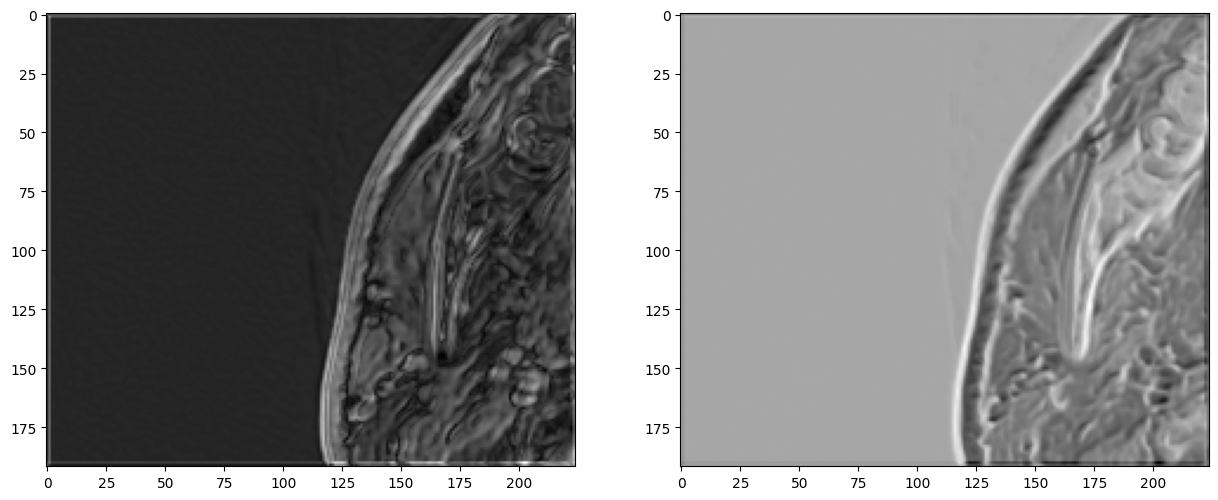

In [146]:
fig, axes = plt.subplots(1,2, figsize=(15, 15))
axes[0].imshow(plot_q1.cpu().numpy().max(0)[SLC], cmap='gray')
axes[1].imshow(attended_x1.cpu().numpy().max(0)[SLC], cmap='gray')

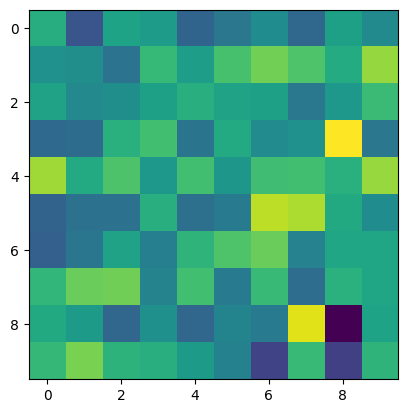

In [147]:
plt.imshow(np.random.randn(10, 1000) @ np.random.randn(10, 1000).T)

In [158]:
kk = torch.randn(1000, 10)
qq = torch.randn(1000, 10)

In [161]:
torch.nn.functional.softmax(qq @ kk.T, dim=0).sum(0)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

In [164]:
(torch.nn.functional.softmax(qq, dim=0) @ torch.nn.functional.softmax(kk, dim=1).T).sum(0)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 